# Reproduce the fixed angles conjecture paper

The paper [Fixed-angle conjectures for the quantum approximate optimization algorithm on regular MaxCut graphs](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.104.052419) by Wurtz and Lykov introduces the notion that it is possible to use QAOA angles that depend on the property of the graph and do not require optimization. Specifically, they show this for regular graphs, where the angles only depend on the node degree and the number of repetitions $p$ of the QAOA circuit. They conjecture that it may be true for graphs in general. They also made public the optimal fixed angles for n-regular graphs (with $p=1 \ldots 11$) and for various values of n. 

Here we show how to use the `FixedAngleConjecture` class, and show that these fixed angles do indeed provide good results for n-regular graphs (we do not attempt to prove the conjecture).

Namely, this involves:
1. Creating an n-regular graph to define a MAX-CUT problem
2. Choosing the depth of the QAOA circuit to run
3. Defining the QAOA circuit for the graph
4. Loading the relevant angles
5. Running the QAOA circuit without optimization to obtain estimated cut size

We repeat this process using the following options for initializing the angles:
1. Using the fixed angles
2. Using linearly decreasing $\beta$ and linearly increasing $\gamma$ values that roughly mimic the published optimal angles
3. Using angles randomly chosen between 0 and $\pi$.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from qiskit.circuit.library import qaoa_ansatz
from qiskit.primitives import BitArray
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2, SamplerV2

from qaoa_training_pipeline.evaluation.aer_interface import AerEvaluator
from qaoa_training_pipeline.training.fixed_angle_conjecture import FixedAngleConjecture
from qaoa_training_pipeline.utils.graph_utils import graph_to_operator

# Parameters
DEGREE = 3  # degree of the regular graph
N_NODES = 20  # number of nodes
REPS = 5
SAMPLES = 50
evaluator = AerEvaluator(EstimatorV2())

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


## Helper functions
Let us first define a couple of functions:
1. The first converts a random n-regular graph to a cost-operator.
2. The second calculates the max-cut of a graph using QAOA with given angles (without optimizing them) in the 3 methods described above to obtain the angles.

In [2]:
def get_energies(cost_op: SparsePauliOp, reps: int) -> dict:
    """Calculate the cost_op energies using qaoa with 3 different initial params"""
    # get the fixed angles
    params = FixedAngleConjecture().train(cost_op=cost_op, reps=reps, degree=DEGREE)
    # calculate the energy using the fixed angles
    opt_energy = evaluator.evaluate(cost_op=cost_op, params=params["optimized_params"])
    # calculate the energy using descending (beta) and ascending (gamma) angels
    linspace_energy = evaluator.evaluate(
        cost_op=cost_op,
        params=np.linspace(np.pi / 2, 0, reps).tolist() + np.linspace(0, np.pi / 2, reps).tolist(),
    )
    # calculate the energy using randomly uniform angles
    random_energy = evaluator.evaluate(
        cost_op=cost_op, params=np.random.uniform(0, np.pi, reps * 2).tolist()
    )
    return {"Fixed Angles":opt_energy, 
            "Lin-space Angles": linspace_energy, 
            "Random Angles": random_energy,}


Estimate the energy values of the qaoa circuit $N$ times with the 3 options.
This could take a couple of minutes.

In [3]:
def get_graph_energies(degree: int, n_nodes: int, reps: int) -> dict:
    """Combine creating the graph and getting the cost_op into a single function"""
    graph = nx.random_regular_graph(degree, n_nodes)
    cost_op = graph_to_operator(graph, pre_factor=-0.5)
    return get_energies(cost_op, reps)


energies = pd.DataFrame(
    [get_graph_energies(DEGREE, N_NODES, REPS) for _ in range(SAMPLES)]
)
energies.head()

,Fixed Angles,Lin-space Angles,Random Angles
0,9.728246,2.265136,0.182681
1,9.317438,2.178738,-4.145722
2,10.422720,1.979094,1.245547
3,9.492197,2.718162,-0.438366
4,10.578995,2.822443,-0.835859


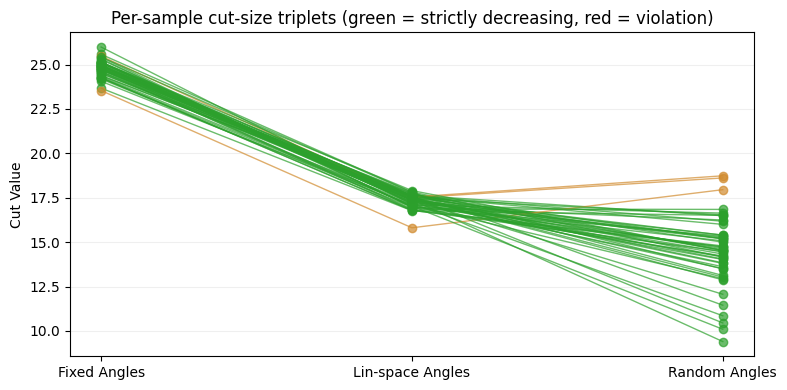

In [4]:
plt.figure(figsize=(8, 4))
x_positions = [0, 1, 2]
x_labels = ["Fixed Angles", "Lin-space Angles", "Random Angles"]
# the cut value is the energy plus number of edges /2
cut_values = energies + N_NODES*DEGREE/4
for i, row in cut_values.iterrows():
    y = [row["Fixed Angles"], row["Lin-space Angles"], row["Random Angles"]]
    # Color by whether the strict order holds for this sample
    if row["Fixed Angles"] <= max(row["Lin-space Angles"], row["Random Angles"]):
        COLOR = "#d62728"
    elif row["Lin-space Angles"] <= row["Random Angles"]:
        COLOR = "#D18B2E"
    else:
        COLOR = "#2ca02c"

    plt.plot(x_positions, y, marker="o", color=COLOR, alpha=0.7, linewidth=1)

plt.xticks(x_positions, x_labels, rotation=0)
# plt.xlabel("Configuration")
plt.ylabel("Cut Value")
plt.title("Per-sample cut-size triplets (green = strictly decreasing, red = violation)")
plt.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()

We see that in all cases the fixed angles provide the best max-cut values without optimization. 
In most cases, the linearly spaced beta and gamma values already provide values 
that are better than random angles, but not by much. 
This is despite the fact that the optimal angles are monotonously decreasing and increasing
(see ) .

## Check cut sizes
We saw that using fixed angles (without any optimization) provide much better energy values and thus cut values. 
However, from these average values it is difficult to see that we are very close to the optimal cut value.
Also, we can ask what about the best cut achieved rather than the average cut. 
to do this, we use a sampler instead of an evaluator and run the qaoa ansatz to sample multiple values of the QAOA circuit

### A side-note about the pre-factor
The conventions section of the readme mentions that when translating from a graph to a MAX_CUT Hamiltonian it is important to use a  pre-factor=-0.5. This may sound surprising because the optimization doesn't depend on a multiplicative factor of the whole Hamiltonian. 
However, remember that QAOA applies operators of the type $e^{-i\gamma\H_c}. If $H_c$ is multiplied by some factor then $\gamma$ needs to be divided by that same factor to make sure that the QAOA dynamics remain the same. So when performing optimization of the angles the pre-factor doesn't matter, but when using the pre-loaded fixed angles the pre-factor is essential. As an example, below we show how we manipulate this pre-factor. Note that this is just for demonstration purposes and is NOT required.

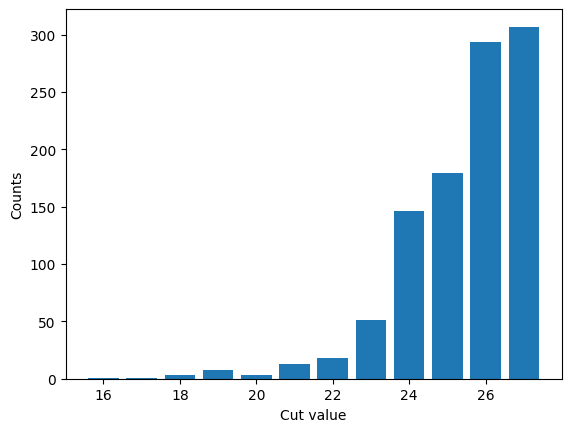

In [8]:
# repeat preparation of a graph, extract fixed angles
pre_factor = -.5

PRE_FACTOR_SCALING = 10  # this is used just for demonstration purposes. Remove this for real code
demonstrate_rescaling = True
if demonstrate_rescaling:
    pre_factor *= PRE_FACTOR_SCALING
graph_for_sampling = nx.random_regular_graph(DEGREE, N_NODES)
cost_operator = graph_to_operator(graph_for_sampling, pre_factor=pre_factor)
circuit = qaoa_ansatz(cost_operator, reps=REPS)
circuit.measure_all()
sampler = SamplerV2()

# load the fixed angles and 
fa_params = FixedAngleConjecture().train(cost_operator, REPS, DEGREE)
# correct the gamma part by the scaling factor. once again, this rescaling is not needed 
if demonstrate_rescaling:
    n = len(fa_params["optimized_params"])
    for i in range(n//2, n):
        fa_params["optimized_params"][i] /= PRE_FACTOR_SCALING

# sample from the graph and count bitstrings
results = sampler.run([(circuit, fa_params["optimized_params"])]).result()
joined_data = results[0].join_data()
assert isinstance(joined_data, BitArray)
counts = joined_data.get_counts()
counts_df = pd.DataFrame(list(counts.items()), columns=["bitstring", "counts"])


# convert each bitstring to a cut value
def cut_size_from_graph(graph, bitstring):
    """Given a bitstring assignment use the graph to calculate the cut value

    Note that this value is identical to the energy plus half the number of edges
    """
    assignment = [node for node, bit in zip(graph.nodes(), bitstring[::-1]) if bit == "1"]
    cut_value = nx.cut_size(graph, assignment, weight="weight")
    return cut_value


counts_df["cut_value"] = counts_df["bitstring"].apply(
    lambda b: cut_size_from_graph(graph_for_sampling, b)
)

# plot a histogram of the cut values
uniq, inv = np.unique(counts_df["cut_value"], return_inverse=True)
agg = np.bincount(inv, weights=counts_df["counts"])
plt.bar(uniq, agg)
plt.xlabel("Cut value")
plt.ylabel("Counts")
plt.show()

While this is not proof that a better cut doesn't exist, it shows that we are near a local maximum. 

Note that, most often, the optimal value is also one of the most frequent ones.

In [10]:
# for sanity, make sure that the average cut values from the estimator and sampler are the same
energy = evaluator.evaluate(cost_op=cost_operator, params=fa_params["optimized_params"])
if demonstrate_rescaling:
    energy /= PRE_FACTOR_SCALING
print(energy + graph_for_sampling.number_of_edges()/2)
print(np.average(uniq, weights=agg))

25.45338997352464
25.4423828125
